# Using Neural Ratio Estimation to enhance EoR parameter inference

In [1]:
import torch
from tools.FCN import ANN_Classifier
from tools.RNN import RNN_ANNclassifier
from tools.trainer import train_classifier
from tools.utils import gridplot

import numpy as np
import matplotlib.pyplot as plt
import emcee


## Experiment 1

In the first experiment, we use scattering transform as summary statistics.

### Load Dataset and Do Normalization
As a demonstration, here we use dataset with thermal noise only.


In [2]:
summary_set=np.load('dataset/signal_with_ns/ST_3D_total.npy')
param_set=np.load('dataset/signal_with_ns/params.npy')


#simple normalization of data
sum_mean=np.mean(summary_set,axis=0)
sum_std=np.std(summary_set,axis=0)
summary_set=(summary_set-sum_mean)/sum_std


para_mean=np.array([5,1.7])
para_std=np.array([1,0.7])
param_set=(param_set-para_mean)/para_std

### Initialize model and train ratio estimator
Here we use a simple FCN. The NN takes parameter-summary pairs as input and learns the likelihood ratio
\begin{equation}
   r(\boldsymbol{\theta},\mathbf{x})=\frac{p(\boldsymbol{\theta},\mathbf{x})}{p(\mathbf{x}) p(\boldsymbol{\theta})}=\frac{p(\mathbf{x} \mid \boldsymbol{\theta})}{p(\mathbf{x})}
   %=\frac{p(\boldsymbol{\theta} \mid \mathbf{x})}{p(\boldsymbol{\theta})}
\end{equation}

In [ ]:
init_model=ANN_Classifier(data_dim=66,para_dim=2,hidden_dims=[256,128,64,32],apply_dropout=True,dropout=0.2)

model=train_classifier(init_model,summary_set,param_set,train_params={'epochs':100,'batch_size':20,'learning_rate':1e-1,'validation_fraction':10,})

### Test our trained model
We load a new test sample and try to infer its parameters using the learned likelihood ratio

In [6]:
#load test data sample

datas=np.load(f"dataset/summary_data/ns_test/bright-total.npy")
params=np.load("dataset/summary_data/obs_test/bright-y.npy")

true_para=params.copy()

datas=(datas-sum_mean)/sum_std
params=(params-para_mean)/para_std

In [7]:
true_para

array([5.47712125, 2.30103   ])

In [8]:
datas=torch.tensor(datas[np.newaxis,:],dtype=torch.float)
params=torch.tensor(params[np.newaxis,:],dtype=torch.float)

datas=datas.to(device='cuda')
params=params.to(device='cuda')

logp =torch.sigmoid(model(datas,params))
p=logp.cpu().detach().numpy()

Define likelihood functions for sampling

In [9]:

def log_likelihood(params, datas):

    params=torch.tensor(params[np.newaxis,:],dtype=torch.float32,device='cuda')

    log_R = model(datas,params).detach().cpu().numpy()

#     p = model(datas,params).detach().cpu().numpy()
    
#     log_R = np.log((p+1e-6)/(1-p+1e-6))
    
    return log_R

def log_prior(params):
    params=params*para_std+para_mean
    Tvir,zeta = params
    if 4.0 < Tvir < 6.0 and 1.0<zeta<2.4:
        return 0.0
    return -np.inf

def log_prob(params, datas):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,datas)


Sampling

In [10]:
init_param=np.random.uniform(size=(4, 2))*np.array([2,1.4])+np.array([4,1])
pos=(init_param-para_mean)/para_std


nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=([datas]))

sampler.run_mcmc(pos, 10000);

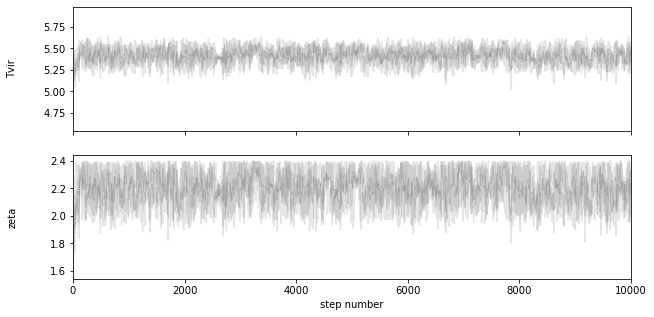

In [11]:
fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
samples = sampler.chain
samples=samples*para_std+para_mean
labels = ["Tvir", "zeta"]
for i in range(ndim):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(samples[w, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples[0]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [12]:
flat_samples_st=samples[:,2000:,:].reshape(-1,2)
print(flat_samples_st.shape)

(32000, 2)


### Plot inference results

/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(
/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(


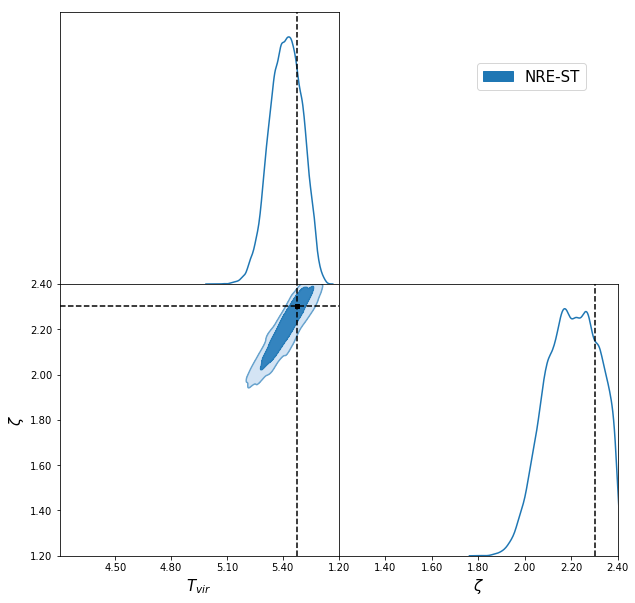

In [14]:
fig=gridplot([flat_samples_st],data_names=['NRE-ST'],true_para=true_para,para_mins=[4.2,1.2],para_maxs=[5.7,2.4],para_names=['T_{vir}','\zeta'])

## Experiments 2

In the second experiment, we consider RNN-based summaries.

### Load Dataset and Do Normalization
As a demonstration, here we use dataset with thermal noise only. We use Scattering Transform as an intial compression to reduce the dimension of the input.


In [25]:
summary_set=np.load('dataset/signal_with_ns/ST_3D.npy')
param_set=np.load('dataset/signal_with_ns/params.npy')


#simple normalization of data
sum_mean=np.mean(summary_set,axis=0)
sum_std=np.std(summary_set,axis=0)
summary_set=(summary_set-sum_mean)/sum_std
 

para_mean=np.array([5,1.7])
para_std=np.array([1,0.7])
param_set=(param_set-para_mean)/para_std

### Initialize model and train ratio estimator
Here we use a simple FCN as ratio estimaor and a RNN as a compressor. The output summary statistics have the same dimension as the ST used in the last experiment. The NN takes parameter-summary pairs as input and learns the likelihood ratio
\begin{equation}
   r(\boldsymbol{\theta},\mathbf{x})=\frac{p(\boldsymbol{\theta},\mathbf{x})}{p(\mathbf{x}) p(\boldsymbol{\theta})}=\frac{p(\mathbf{x} \mid \boldsymbol{\theta})}{p(\mathbf{x})}
   %=\frac{p(\boldsymbol{\theta} \mid \mathbf{x})}{p(\boldsymbol{\theta})}
\end{equation}

In [ ]:
init_model=RNN_ANNclassifier(seq_len=10,feature_size=66,param_dim=2,RNN_hidden_dim=66,RNN_num_layers=3,fc_hidden_dims=[128,64,16],apply_dropout=True,dropout=0.2)

model=train_classifier(init_model,summary_set,param_set,train_params={'epochs':100,'batch_size':20,'learning_rate':1e-1,'validation_fraction':10,})

### Test our trained model
We load a new test sample and try to infer its parameters using the learned likelihood ratio

In [27]:
#load test data sample

datas=np.load(f"dataset/summary_data/ns_test/bright.npy")
params=np.load("dataset/summary_data/obs_test/bright-y.npy")

true_para=params.copy()

datas=(datas-sum_mean)/sum_std
params=(params-para_mean)/para_std

In [28]:
true_para

array([5.47712125, 2.30103   ])

In [ ]:
datas=torch.tensor(datas[np.newaxis,:],dtype=torch.float)
params=torch.tensor(params[np.newaxis,:],dtype=torch.float)

datas=datas.to(device='cuda')
params=params.to(device='cuda')

logp =torch.sigmoid(model(datas,params))
p=logp.cpu().detach().numpy()

Define likelihood functions for sampling

In [30]:

def log_likelihood(params, datas):

    params=torch.tensor(params[np.newaxis,:],dtype=torch.float32,device='cuda')

    log_R = model(datas,params).detach().cpu().numpy()

#     p = model(datas,params).detach().cpu().numpy()
    
#     log_R = np.log((p+1e-6)/(1-p+1e-6))
    
    return log_R

def log_prior(params):
    params=params*para_std+para_mean
    Tvir,zeta = params
    if 4.0 < Tvir < 6.0 and 1.0<zeta<2.4:
        return 0.0
    return -np.inf

def log_prob(params, datas):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,datas)


Sampling

In [31]:
init_param=np.random.uniform(size=(4, 2))*np.array([2,1.4])+np.array([4,1])
pos=(init_param-para_mean)/para_std


nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=([datas]))

sampler.run_mcmc(pos, 10000);

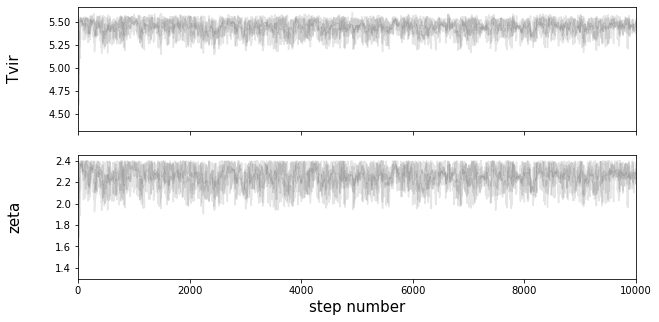

In [32]:
fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
samples = sampler.chain
samples=samples*para_std+para_mean
labels = ["Tvir", "zeta"]
for i in range(ndim):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(samples[w, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples[0]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [33]:
flat_samples_rnn=samples[:,2000:,:].reshape(-1,2)
print(flat_samples_rnn.shape)

(32000, 2)


### Plot inference results

/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(
/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(


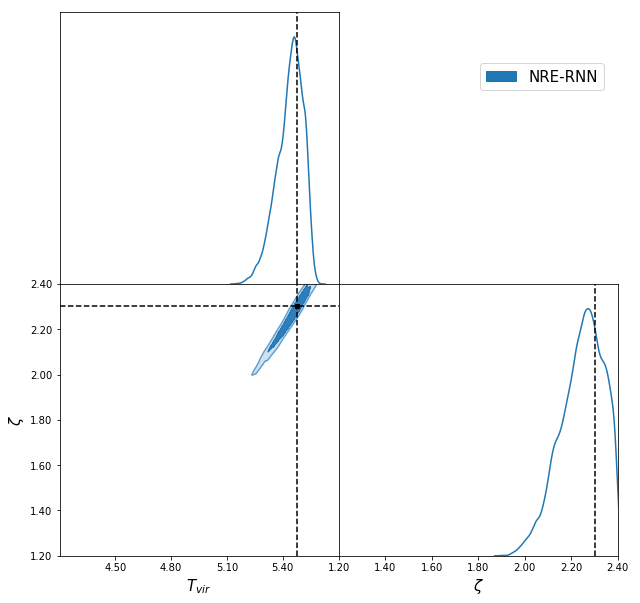

In [34]:

fig=gridplot([flat_samples_rnn],data_names=['NRE-RNN'],true_para=true_para,para_mins=[4.2,1.2],para_maxs=[5.7,2.4],para_names=['T_{vir}','\zeta'])

## Make comparisons between ST-based results and NN-based results

As we can see, the NN can potentially learn better data summaries.

/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(
/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(
/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(
/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(


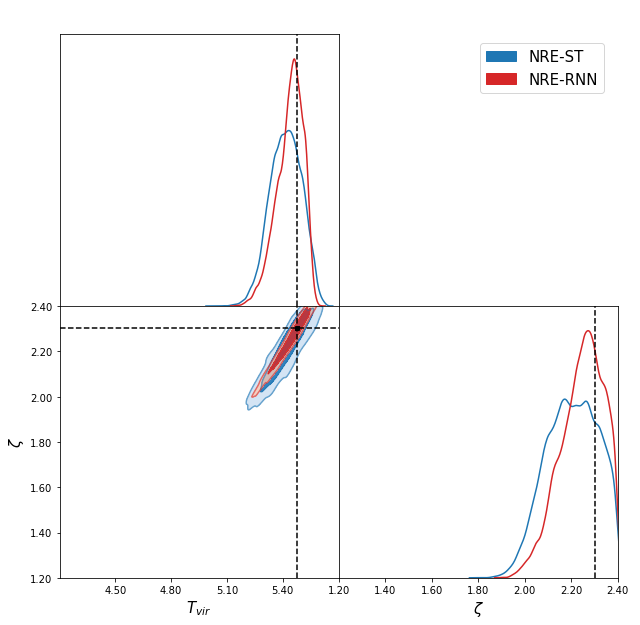

In [35]:

fig=gridplot([flat_samples_st,flat_samples_rnn],data_names=['NRE-ST','NRE-RNN'],true_para=true_para,para_mins=[4.2,1.2],para_maxs=[5.7,2.4],para_names=['T_{vir}','\zeta'])